## "Deep Dream" an artistic image modification technique
![title](./pics/deep-dream.png)

In [53]:
#imports

#keras imports
from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image

#general imports 
from IPython.display import display, Markdown #just to display markdown
import numpy as np
import scipy
import cv2

# visualiaztion imports
%matplotlib inline
import matplotlib.pyplot as plt

## Implementing Deep Dream in Keras

In [18]:
# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',include_top=False)


# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}


### define loss to be maximized

defining a tensor that contains our loss, i.e. the weighted sum of the L2 norm of the activations of the layers listed above

In [19]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

### The gradient ascent process

In [20]:
# This holds our generated image
dream = model.input
# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]

fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

### Running gradient ascent over different successive scales

#### Auxiliary functions

In [45]:
def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    imageio.imwrite
    
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [48]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.
# Fill this to the path to the image you want to use
base_image_path = './pics/donuts.png'
# Load the image into a Numpy array
img = preprocess_image(base_image_path)
# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]


print (successive_shapes)
print (img.shape)
# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
save_img(img, fname='final_dream.png')

[(340, 345), (477, 484), (668, 678)]
(1, 668, 678, 3)
Processing image shape (340, 345)
...Loss value at 0 : 2.166617
...Loss value at 1 : 2.8765364
...Loss value at 2 : 3.6589448
...Loss value at 3 : 4.40296
...Loss value at 4 : 5.1397586
...Loss value at 5 : 5.8432636
...Loss value at 6 : 6.52345
...Loss value at 7 : 7.150318
...Loss value at 8 : 7.7557592
...Loss value at 9 : 8.3504715
...Loss value at 10 : 8.912292
...Loss value at 11 : 9.49704


/Users/sanjyotzade/anaconda3/envs/francois/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/sanjyotzade/anaconda3/envs/francois/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (477, 484)
...Loss value at 0 : 3.3372521
...Loss value at 1 : 4.7361674
...Loss value at 2 : 5.86198
...Loss value at 3 : 6.839449
...Loss value at 4 : 7.7082553
...Loss value at 5 : 8.536424
...Loss value at 6 : 9.307288
...Loss value at 7 : 9.977934
Processing image shape (668, 678)
...Loss value at 0 : 3.4497395
...Loss value at 1 : 4.785638
...Loss value at 2 : 5.94196
...Loss value at 3 : 6.9119477
...Loss value at 4 : 7.805131
...Loss value at 5 : 8.64377
...Loss value at 6 : 9.394194


### results

### original Vs generated images

Text(0.5, 1.0, 'original_scale_gen_668*678')

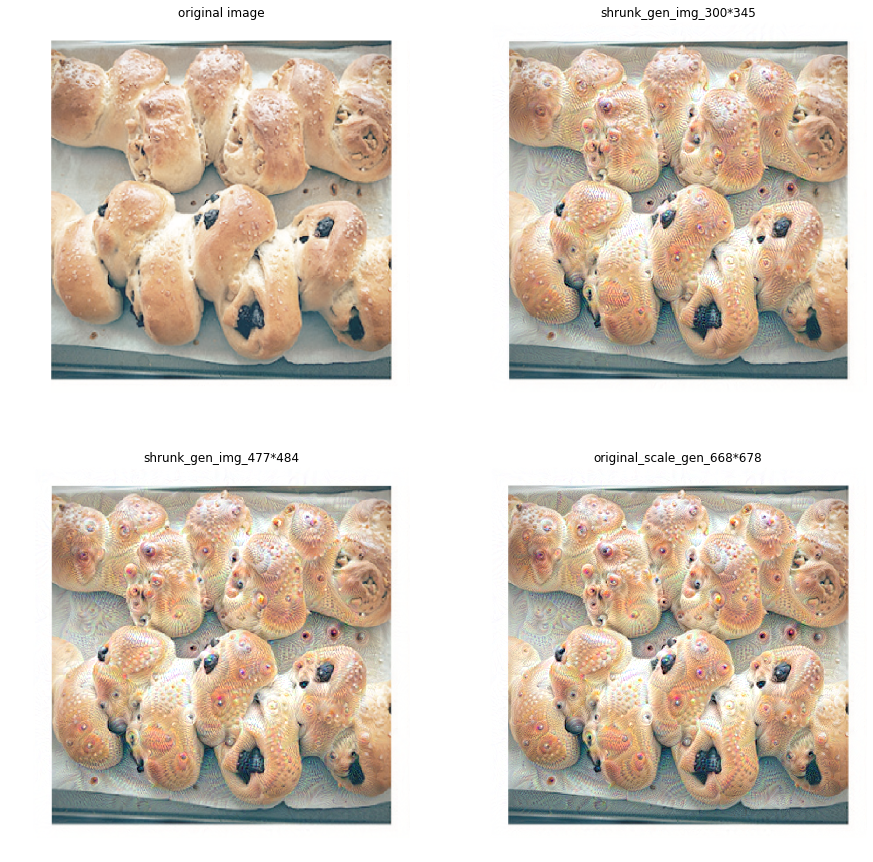

In [61]:
def read_image(path):
    return  cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

display(Markdown("### original Vs generated images"))    

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(read_image("./pics/donuts.png"))
plt.axis('off')
plt.title("original image")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(read_image("./pics/dream_at_scale_(340, 345).png"))
plt.axis('off')
plt.title("shrunk_gen_img_300*345")
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(read_image("./pics/dream_at_scale_(477, 484).png"))
plt.axis('off')
plt.title("shrunk_gen_img_477*484")
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(read_image("./pics/dream_at_scale_(668, 678).png"))
plt.axis('off')
plt.title("original_scale_gen_668*678")